In [34]:
import duckdb
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [2]:
# Sql Config
%load_ext sql
    
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

In [3]:
# Connect to duck db 
%sql duckdb:///powerbi.db

In [4]:
# Query view with data aggregated for forecast
%sql df << SELECT * FROM main.salesDataforPrediction WHERE y >= 0;

In [36]:
# Add cap variable and column
cap = 40000
df['cap'] = cap

floor = 10
df['floor'] = floor

# Transform in datetime format ds column
df['ds'] = pd.to_datetime(df['ds'])

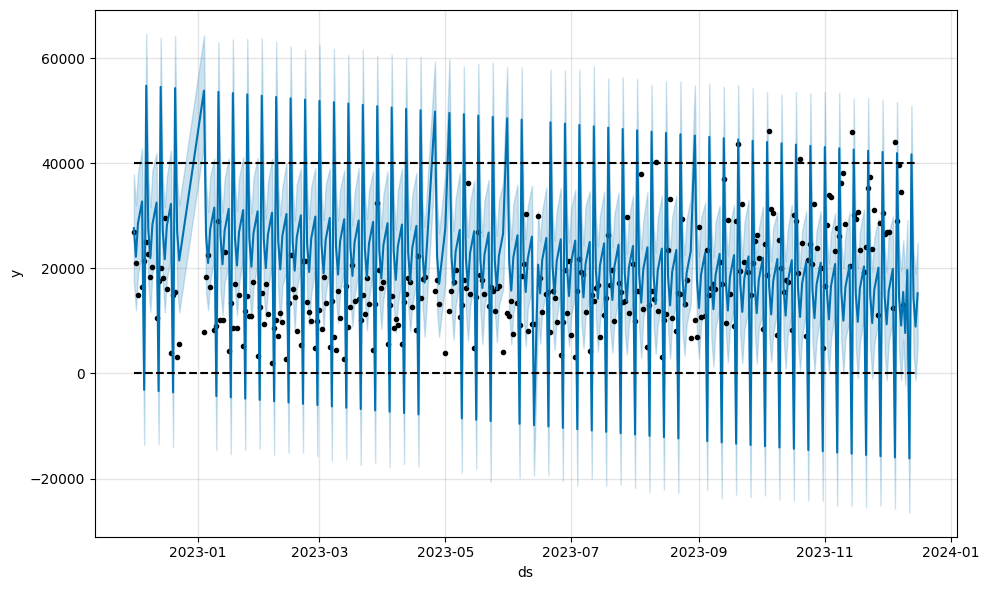

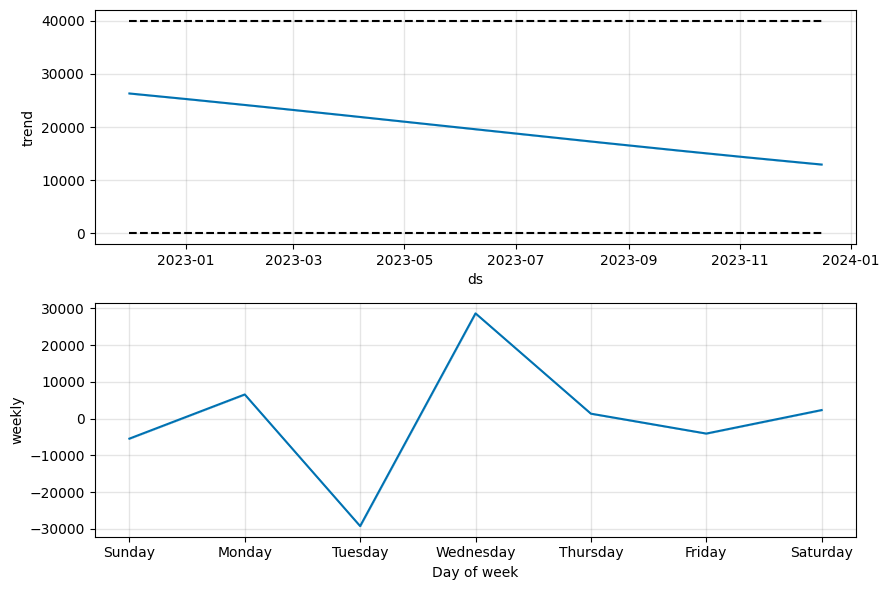

In [55]:
# Prophet model
model = Prophet(
    #yearly_seasonality = True,
    #weekly_seasonality = True,
    #interval_width = 0.95,
    #holidays_prior_scale = 0.1,
    #changepoint_prior_scale = 1,
    growth = 'logistic'
)

# Fit model and generatge predictions
model.fit(df)

future = model.make_future_dataframe(periods = 7)
future['cap'] = cap
future['floor'] = floor

forecast = model.predict(future)

# Plot the results and the components of the model
model.plot(forecast)
model.plot_components(forecast)
plt.show()

In [40]:
# Generate metrics for model analysis
import logging
import contextlib

logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)

with contextlib.redirect_stdout(None):
    crossValidationDF = cross_validation(
        model,
        horizon = '7 days',
        period = '30 days',
        initial = '366 days',
        parallel = 'processes'
    )    

In [41]:
# Display performance metrics for model
metrics = performance_metrics(crossValidationDF)
metrics.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,2.769382e+08,16641.458892,16641.458892,1.342486,1.342486,0.803286,0.0
1,3 days,2.235507e+08,14951.611574,14951.611574,0.338893,0.338893,0.408032,0.0
2,4 days,7.386291e+04,271.777326,271.777326,0.009363,0.009363,0.009320,1.0
3,5 days,1.036705e+08,10181.869891,10181.869891,0.257040,0.257040,0.294947,1.0
4,6 days,2.399588e+07,4898.559390,4898.559390,0.142152,0.142152,0.153029,1.0


In [33]:
# Save prediction to duckdb
quantityPrediction = forecast[['ds', 'trend', 'yhat_lower', 'yhat_upper', 'yhat']]

engine = create_engine('duckdb:///powerbi.db')
quantityPrediction.to_sql('quantityPrediction', con = engine, if_exists = 'replace', index = False)

-1